<a href="https://colab.research.google.com/github/sg-peytrignet/algeria24-training/blob/main/1_proximity_coverage_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximity, coverage and demand analysis

## Setting up our environment

We begin by importing Python libraries that will help us analyze school connectivity needs:

- Data handling tools for working with spreadsheets and numbers (pandas, numpy)
- Geographic tools for working with maps and locations (geopandas, scipy)
- Visualization libraries to create graphs and maps (matplotlib, seaborn)

These tools will help us understand where schools are located and how to connect them to the internet.

In [ ]:
!pip install rasterstats contextily summarytools pycountry

In [ ]:
# Data handling
import os
import pandas as pd
import numpy as np
import requests

# Graph and spatial libraries
import geopandas as gpd
from scipy.spatial import cKDTree
from geopy.distance import great_circle
from rasterstats import zonal_stats
from rasterio import open as raster_open
from rasterio.mask import mask
from rasterio.plot import show

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as cx
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from summarytools import dfSummary

# Miscellaneous utilities
import pycountry

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [ ]:
display_folium = False

## Set analysis parameters

We create a simple interface to select which country we want to analyze. This dropdown menu lets us easily switch between different countries to analyze their school connectivity situations. Later sections will add more parameters as needed.

In [ ]:
# @title Parameters
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Algeria',
    layout=item_layout,
    style={'description_width': 'initial'}
)

inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
    ]
)

display(inputs_layout)

## Download school dataset

We're loading a dataset containing information about schools in Algeria. Each school has a unique identifier, its geographical coordinates (latitude and longitude), and a label indicating whether it's currently connected to the internet. The data is loaded into a GeoDataFrame, which is a special type of DataFrame that understands geographical data and can perform spatial operations.

The school data contains the following columns:

| Column            | Description                                             | Example                                    |
|-------------------|---------------------------------------------------------|--------------------------------------------|
| poi_id           | Unique school identifier (UUID)                         | "8dd444f0-2eb1-4d9a-bf57-f032e517683"      |
| dataset_id       | Source data collection identifier                       | "34500f3d-aec9-418b-81ff-1a77d23ba047"     |
| lat              | School's latitude coordinate                            | 31.949701                                   |
| lon              | School's longitude coordinate                           | 33.580467                                   |
| country_code     | Three-letter ISO country code                          | "DZA" (Algeria)                             |
| poi_type         | Type of point of interest                              | "school"                                    |
| is_connected     | Internet connectivity status                           | false                                       |
| connectivity_type| Type of internet connection if available               | NaN (Not Available)                         |
| has_electricity  | Electricity availability status                        | NaN (Not Available)                         |
| electricity_type | Type of electrical supply if available                 | NaN (Not Available)                         |
| label            | Category label for the point of interest               | "school"                                    |
| geometry         | Geographic point representation (lat/lon)              | "POINT (3.580467 31.949701)"               |


In [ ]:
algeria_schools = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_schools.csv")

In [ ]:
algeria_schools_gdf = gpd.GeoDataFrame(algeria_schools[["poi_id","dataset_id","lat","lon"]], geometry=gpd.points_from_xy(algeria_schools.lon, algeria_schools.lat), crs='EPSG:4326').set_index("poi_id")

In [ ]:
algeria_schools_gdf.head()

,dataset_id,lat,lon,geometry
poi_id,,,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.949701,3.580467,POINT (3.58047 31.9497)
a1c86f79-a20e-4001-9ac0-def0831024f1,34500f3d-aec9-418b-81ff-1a77d23ba047,31.976883,3.743190,POINT (3.74319 31.97688)
cb814cd6-0c90-49d6-b847-d163a95e77e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.950062,3.541530,POINT (3.54153 31.95006)
194188d3-94b1-4e03-a002-25e8c868bfae,34500f3d-aec9-418b-81ff-1a77d23ba047,31.952468,3.529267,POINT (3.52927 31.95247)
c32d3c71-c574-4701-b761-ec757dbe2d4f,34500f3d-aec9-418b-81ff-1a77d23ba047,31.601909,3.676841,POINT (3.67684 31.60191)


## Download cell site dataset

Similar to the school dataset, we're loading information about cell site locations. Each tower record includes its coordinates, a unique identifier, the technologies it supports, and antenna heights. This information is crucial for determining whether a cell site could potentially provide coverage to nearby schools.

The cell site data contains the following columns:

| Column                      | Description                                             | Example                                    |
|----------------------------|---------------------------------------------------------|--------------------------------------------|
| ict_id                     | Unique identifier for ICT infrastructure                | "ffc1a8b1-3f54-4692-9cc7-2249d9fbdbcc"    |
| dataset_id                 | Source data collection identifier                       | "baddd192-284a-4025-8a10-f00929f3456a"     |
| lat                        | Cell site's latitude coordinate                         | 36.738                                      |
| lon                        | Cell site's longitude coordinate                        | 2.9742                                      |
| radio_type                 | Mobile network generation                              | "4G"                                        |
| antenna_height             | Height of antenna in meters                            | 25                                          |
| backhaul_type             | Type of backhaul connection                            | NaN (Not Available)                         |
| backhaul_throughput_mbps   | Backhaul connection speed in Mbps                     | NaN (Not Available)                         |
| operator_name              | Name of telecom operator                              | NaN (Not Available)                         |
| azimuth_degrees           | Antenna direction in degrees                          | NaN (Not Available)                         |
| tower_height              | Total height of tower structure                       | NaN (Not Available)                         |
| geometry                   | Geographic point representation (lon/lat)              | "POINT (2.9742 36.738)"                    |

In [ ]:
algeria_cellsites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_cell_sites.csv")

In [ ]:
algeria_cellsites_gdf = gpd.GeoDataFrame(algeria_cellsites, geometry=gpd.points_from_xy(algeria_cellsites.lon, algeria_cellsites.lat), crs='EPSG:4326').set_index("ict_id")

In [ ]:
algeria_cellsites_gdf.head()

,dataset_id,lat,lon,radio_type,antenna_height,backhaul_type,backhaul_throughput_mbps,operator_name,azimuth_degrees,tower_height,geometry
ict_id,,,,,,,,,,,
ffc1a8b1-3f54-4692-9cc7-2249d9fbdbcc,baddd192-284a-4025-8a10-f00929f3456a,36.7380,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9742 36.738)
3e8514ad-abc8-4ed0-b80d-01ac43f80bdd,baddd192-284a-4025-8a10-f00929f3456a,36.7447,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9742 36.7447)
7517a4ca-33b8-4a15-bf03-119dc75f3871,baddd192-284a-4025-8a10-f00929f3456a,36.7453,2.9849,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.9849 36.7453)
ad795a2c-a08a-46f7-980e-e4fa98a32326,baddd192-284a-4025-8a10-f00929f3456a,36.7491,3.0012,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.0012 36.7491)
f9599329-bc4a-48ff-9085-deda962262e8,baddd192-284a-4025-8a10-f00929f3456a,36.7503,3.0027,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.0027 36.7503)


## Download transmission node dataset

Similar to the school dataset, we load information about fiber transmission nodes. These are the existing connection points in our network that schools can potentially connect to.

| Column                    | Description                                             | Example                                      |
|---------------------------|---------------------------------------------------------|----------------------------------------------|
| ict_id                    | Unique identifier for fiber node location               | "ada877d8-df1a-4d60-b86a-6561eca45f6c"      |
| dataset_id                | Source data collection identifier                       | "1a452a88-1f87-4910-95ed-45179330f4a0"       |
| lat                       | Fiber node's latitude coordinate                        | 36.480870                                    |
| lon                       | Fiber node's longitude coordinate                       | 2.835004                                     |
| operator_name             | Name of network operator                                | NaN (Not Available)                          |
| infrastructure_type       | Type of network infrastructure                          | "fiber"                                      |
| node_status               | Operational status of node                              | "operational"                                |
| equipped_capacity_mbps    | Current bandwidth capacity in Mbps                      | NaN (Not Available)                          |
| potential_capacity_mbps   | Maximum possible bandwidth capacity in Mbps             | NaN (Not Available)                          |
| geometry                  | Geographic point representation (lon/lat)               | "POINT (2.835004 36.480870)"                 |


In [ ]:
algeria_nodes = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_nodes.csv")

In [ ]:
algeria_nodes_gdf = gpd.GeoDataFrame(algeria_nodes[["ict_id","dataset_id","lat","lon"]], geometry=gpd.points_from_xy(algeria_nodes.lon, algeria_nodes.lat), crs='EPSG:4326').set_index("ict_id")

In [ ]:
algeria_nodes_gdf.head()

,dataset_id,lat,lon,geometry
ict_id,,,,
ada877d8-df1a-4d60-b86a-6561eca45f6c,1a452a88-1f87-4910-95ed-45179330f4a0,36.480870,2.835004,POINT (2.835 36.48087)
4f32bf64-8ccf-4748-9834-024426d1436b,1a452a88-1f87-4910-95ed-45179330f4a0,36.135791,2.915544,POINT (2.91554 36.13579)
2fee309c-5ee3-4cd2-9dd7-97c181730057,1a452a88-1f87-4910-95ed-45179330f4a0,36.766537,3.467671,POINT (3.46767 36.76654)
1fed4fe3-7010-44b3-8879-fb419cee8114,1a452a88-1f87-4910-95ed-45179330f4a0,36.508079,1.314256,POINT (1.31426 36.50808)
dd73c0b1-b9ec-4bdb-82f8-d63c3621fc10,1a452a88-1f87-4910-95ed-45179330f4a0,35.483203,-0.598996,POINT (-0.599 35.4832)


## Proximity analysis

This section calculates how far each school is from the nearest cell tower and fiber node. We:

1. Use a special algorithm (KDTree) to efficiently find the closest infrastructure
2. Calculate exact distances using the Haversine formula (which accounts for Earth's curvature)
3. Add these distances to our school data

In [ ]:
# @title Functions
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance."""
    return great_circle((lat1, lon1), (lat2, lon2)).meters

def calculate_nearest_sites(source_gdf, target_gdf, id_col='ict_id'):
    """
    Calculates the nearest site from `target_gdf` for each entry in `source_gdf` using a KDTree and Haversine distance.

    Args:
        source_gdf (GeoDataFrame): GeoDataFrame with locations to find nearest neighbors for.
        target_gdf (GeoDataFrame): GeoDataFrame of possible neighbor locations.
        id_col (str): Column name for unique IDs in `target_gdf`.

    Returns:
        GeoDataFrame: Updated `source_gdf` with nearest site ID and distance columns.
    """
    # Copy input file
    source_gdf = source_gdf.copy()
    target_gdf = target_gdf.copy()

    # Build KDTree from target lat/lon
    target_coords = target_gdf[['lat', 'lon']].values
    kdtree = cKDTree(target_coords)

    # Prepare lists for results
    nearest_sites, distances = [], []

    for _, row in source_gdf.iterrows():
        # Query KDTree and calculate Haversine distance to nearest neighbor
        _, idx = kdtree.query((row['lat'], row['lon']))
        nearest_target = target_gdf.iloc[idx]
        distance_m = haversine_distance(row['lat'], row['lon'], nearest_target['lat'], nearest_target['lon'])

        # Append the nearest node and distance
        nearest_sites.append(nearest_target.name)
        distances.append(distance_m)

    # Add nearest neighbor data to source_gdf
    source_gdf['nearest_site_id'] = nearest_sites
    source_gdf['nearest_site_distance'] = distances

    # Format output
    output = source_gdf[["nearest_site_id","nearest_site_distance"]]

    return output

### Cell sites

In [ ]:
nearest_cell_sites = calculate_nearest_sites(algeria_schools_gdf, algeria_cellsites_gdf)
nearest_cell_sites = nearest_cell_sites.rename(columns={"nearest_site_id":"nearest_cell_site_id","nearest_site_distance":"cell_site_distance"}, inplace=False)

In [ ]:
nearest_cell_sites.head()

,nearest_cell_site_id,cell_site_distance
poi_id,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,c5bd5ee1-e4d9-434e-9be3-fd8b424e3a85,58623.007781
a1c86f79-a20e-4001-9ac0-def0831024f1,c5bd5ee1-e4d9-434e-9be3-fd8b424e3a85,54599.624308
cb814cd6-0c90-49d6-b847-d163a95e77e0,c5bd5ee1-e4d9-434e-9be3-fd8b424e3a85,59410.294177
194188d3-94b1-4e03-a002-25e8c868bfae,c5bd5ee1-e4d9-434e-9be3-fd8b424e3a85,59457.418987
c32d3c71-c574-4701-b761-ec757dbe2d4f,c5bd5ee1-e4d9-434e-9be3-fd8b424e3a85,96190.869904


In [ ]:
algeria_schools_gdf = algeria_schools_gdf.merge(nearest_cell_sites, left_index=True, right_index=True)

### Transmission nodes

In [ ]:
nearest_transmission_nodes = calculate_nearest_sites(algeria_schools_gdf, algeria_nodes_gdf)
nearest_transmission_nodes = nearest_transmission_nodes.rename(columns={"nearest_site_id":"nearest_transmission_node_id","nearest_site_distance":"transmission_node_distance"}, inplace=False)

In [ ]:
nearest_transmission_nodes.head()

,nearest_transmission_node_id,transmission_node_distance
poi_id,,
8dd444f0-2eb1-4d9a-bf57-f032e51768e0,418451f1-6a33-4be2-aa9b-d841e0d9c505,60679.529620
a1c86f79-a20e-4001-9ac0-def0831024f1,418451f1-6a33-4be2-aa9b-d841e0d9c505,57250.907515
cb814cd6-0c90-49d6-b847-d163a95e77e0,418451f1-6a33-4be2-aa9b-d841e0d9c505,61309.775174
194188d3-94b1-4e03-a002-25e8c868bfae,418451f1-6a33-4be2-aa9b-d841e0d9c505,61303.976752
c32d3c71-c574-4701-b761-ec757dbe2d4f,418451f1-6a33-4be2-aa9b-d841e0d9c505,98632.546164


In [ ]:
algeria_schools_gdf = algeria_schools_gdf.merge(nearest_transmission_nodes, left_index=True, right_index=True)

### Descriptive statistics

- The median distance to a cell site is 60 kilometers: half of schools in Algeria are more than 60km away from a cell site. Some schools are over 1,000 kilometers away from a cell site.
- For transmission nodes, the median distance is 10 kilometers. There aren't as many extreme outliers as observed for cell sites.

In [ ]:
dfSummary(algeria_schools_gdf[['cell_site_distance', 'transmission_node_distance']]/1000)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cell_site_distance[float64],Mean (sd) : 99.2 (135.1)min < med < max:0.0 < 59.4 < 1250.0IQR (CV) : 127.9 (0.7),"10,646 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB+ElEQVR4nO3dwYraUBSH8XPiKHGUBHHQnZvZz8KlD9GH7bZLwbfoCwhhjHgbq6S3my66aJ3mDrb/ku+3lXOj8HFDMHA9xmiAiuxffwHgZw+3PnT3sZmNEte+xBibxFn01G+DdPfxfD7/UBTFLGXh4/H46u4fiRJd3NohR0VRzDabTVOW5bnLonVd57vdblZV1cjMCBJ/7OYt28ysLMvzYrH4krD2OGEGPcdDDaQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKS8eXBSqrZth2ZWuHvKOOck9tRdggwhDK/X68tqtRoMBoNOx9KZcU5in90lyMvl8pDn+eN6vT4vl8vXLrOck9hvd7tlm5lNJhPOSUQnPNRACkFCCkFCCkFCCkFCCkFCCkFCCkFCCkFCCkFCyl3/OkzFm0L9JRckbwr1m1yQ731TaLvdLqqqenL3Y8LlMzP7ljD33ll29R/eDLKu67zroqfTKTczCyHk+/3+MWU2RdM0ybtr27bDEMLzdDr9nGXZ9W/NmpkdDoeTu38ys853hP/U1xjjL3/rdyyrpvmllnNMAAAAAElFTkSuQmCC"">",0(0.0%)
2,transmission_node_distance[float64],Mean (sd) : 16.5 (19.2)min < med < max:0.0 < 10.5 < 261.4IQR (CV) : 20.2 (0.9),"10,646 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB4klEQVR4nO3dsW7iUBBG4ZmQoAtENogIOrd0W1DS7Bvsw26bnp7XQAJshDcEhG7aFLsk1yvEL/l8LZorhI5sGRfjMUYDVDzc+wsAnz1e+9Dde2bWbXj2Kcb41nAWLfXPIN29Nx6Pf2VZNmpy8H6/37n7b6JEimtXyG6WZaPFYvGW5/kx5dCqqsJyuRxtNpuumREkvu3qLdvMLM/z42Qy+dPg7F6DGbQcDzWQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQQpCQ8uU22KYul8uTmWXu3mSc5e8tdZMg67p+Op/PP4qi6HQ6naRd22Ysf2+zmwR5Op0eQwj9+Xx+nE6nu5RZlr+3281u2WZmg8GA5e9IwkMNpBAkpBAkpBAkpBAkpBAkpNz0b5+meMvTXnJB/u9bnrIsD+7+ambJs0bMd/dlkFVVhdRDD4dDMDOr6zqs1+t+yux2u30OIfRns5kPh8P3lNmyLJ9Xq9XPoihe7hAzvu89xvjX3/gDykOEbDQq1rYAAAAASUVORK5CYII="">",0(0.0%)


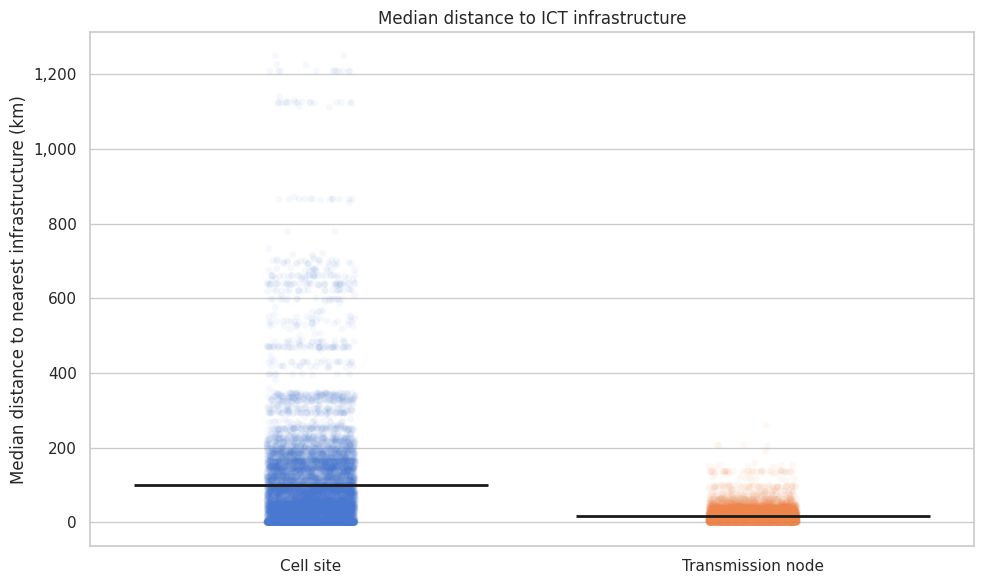

In [ ]:
# @title Figure
# Prepare the data for the box plot
data = algeria_schools_gdf[['cell_site_distance', 'transmission_node_distance']].melt(
    var_name='Distance Type',
    value_name='Distance'
)
data["Distance"] = data["Distance"] / 1000
data['Distance Type'] = data['Distance Type'].replace({
    'cell_site_distance': 'Cell site',
    'transmission_node_distance': 'Transmission node'
})

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a box plot for the two distance metrics
plt.figure(figsize=(10, 6))
sns.boxplot(x='Distance Type', y='Distance', data=data, palette='muted', hue='Distance Type',
            showfliers=False, showbox=False, showcaps=False, showmeans=True, meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10)

# Overlay jittered points using stripplot
sns.stripplot(x='Distance Type', y='Distance', data=data, alpha=0.05, jitter=True, palette='muted', hue='Distance Type')

# Set labels and title
plt.xlabel('')
plt.ylabel('Median distance to nearest infrastructure (km)')
plt.title('Median distance to ICT infrastructure')
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()
plt.show()

## Coverage analysis

Here we look at existing mobile network coverage areas to see which schools are already within range of cellular service. We:

1. Load coverage map data
2. Check which schools fall within coverage areas
3. Visualize the results to understand coverage patterns

Recall that our mobile coverage data is extracted from Ookla, and shows in which areas there have been successful mobile speed tests in the second quarter of 2024.

In [ ]:
# @title Functions
def plot_coverage(gdf, title="Mobile Coverage", fill_color="#1f77b4", alpha=0.6):
    """
    Plot coverage polygons with a basemap
    Parameters:
    gdf : GeoDataFrame with polygon geometry
    title : str, plot title
    fill_color : str, color for polygons (hex code or name)
    alpha : float, transparency level (0 to 1)
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the geodataframe
    gdf.plot(
        ax=ax,
        color=fill_color,
        alpha=alpha,
        edgecolor='white',
        linewidth=0.5
    )

    # Add basemap
    cx.add_basemap(
        ax,
        crs=gdf.crs,
        source=cx.providers.CartoDB.DarkMatter
    )

    # Style the plot
    plt.title(title, pad=20, fontsize=16)
    ax.axis('off')

    # Add a text box with coverage area count
    stats_text = f'Coverage Areas: {len(gdf)}'
    plt.figtext(
        0.02, 0.02, stats_text,
        bbox=dict(facecolor='white', alpha=0.7),
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [ ]:
algeria_mobile_coverage_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_coverage.geojson")

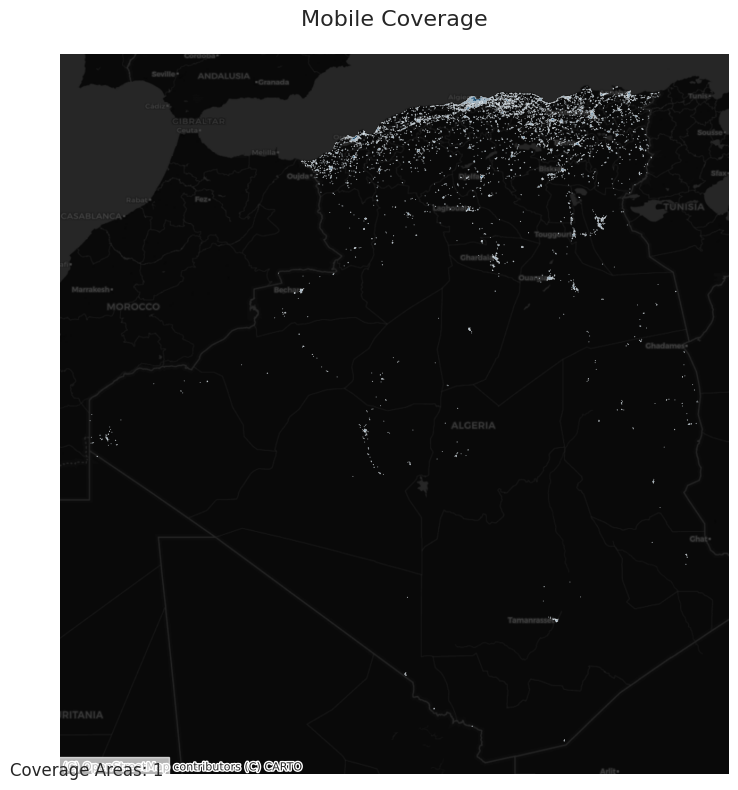

In [ ]:
plot_coverage(algeria_mobile_coverage_gdf)

In [ ]:
coverage = algeria_schools_gdf.sjoin(algeria_mobile_coverage_gdf, how='left', predicate='within')[["coverage"]].fillna(0).astype(bool)

In [ ]:
algeria_schools_gdf = algeria_schools_gdf.merge(coverage, left_index=True, right_index=True)

### Descriptive statistics

There are 1,735 schools in Algeria that do not have cellular coverage, based on the data used here.

<ipython-input-246-424580937b39>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coverage_counts.index, y=coverage_counts.values, palette='Set1')


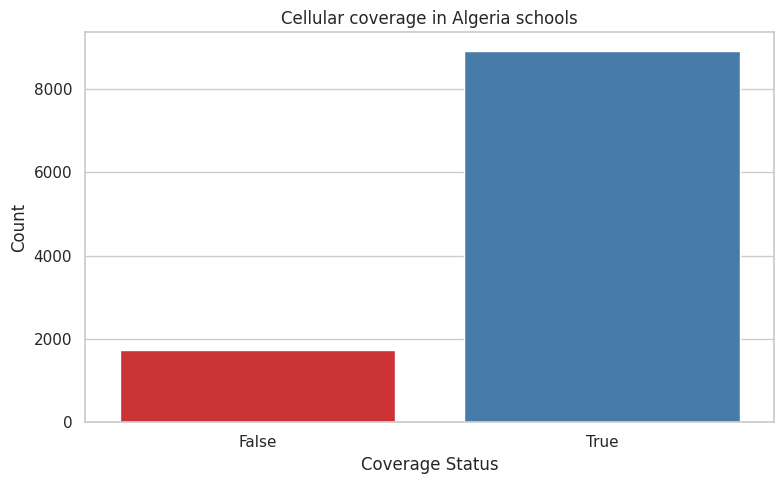

In [ ]:
# @title Figure
# Count the occurrences of True and False in the 'coverage' column
coverage_counts = algeria_schools_gdf['coverage'].value_counts()

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a bar chart for the counts of True and False
plt.figure(figsize=(8, 5))
sns.barplot(x=coverage_counts.index, y=coverage_counts.values, palette='Set1')

# Set labels and title
plt.xlabel('Coverage Status')
plt.ylabel('Count')
plt.title('Cellular coverage in Algeria schools')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## Demand analysis

In general, we would like to know how many people are users of a each amenity (in our case, schools). To do this, we need estimates of how many people live around each point. However, census datasets are rarely very granular - they tend to report population numbers for relatively large administrative areas, like regions or cities. For more granular population counts, we can use open datasets that disaggregate census numbers into smaller areas. Here, we will use data from [WorldPop](https://www.worldpop.org/), an organisation that uses a top-down approach to break down census counts into 1km square grids using information such as building locations.

Having obtained granular population data, we analyze the numbers living around each school to understand potential demand. We:

1. Use WorldPop data to get population estimates
2. Create buffer zones around schools (catchment areas)
3. Calculate how many people live within each school's area
4. Visualize this information to identify high-priority areas

![worldpop](https://www.worldpop.org/wp-content/uploads/2022/03/wb_TD.jpg)

Source: [WorldPop](https://www.worldpop.org/methods/populations/)

Using the controls below, we can select how large the buffer area around each school will be.

In [ ]:
# @title Parameters
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

distance = widgets.FloatSlider(
    description='Catchment area for schools (km):',
    min=0,
    max=10,
    step=1,
    value=1,
    layout=item_layout,
    style={'description_width': 'initial'}
)

inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([distance], layout=widgets.Layout(justify_content='space-between')),
    ]
)

display(inputs_layout)

In [ ]:
# @title Functions
def get_worldpop_dataset_url(country_name, year=2020):
    base_url = "https://d35k53rhvc9u0d.cloudfront.net/worldpop_data/"
    dataset_info_path = base_url + 'assets/wpgpDatasets.csv'

    # Load the dataset paths
    worldpop_dict = pd.read_csv(dataset_info_path)

    # Get the ISO-3 country code
    country_code = pycountry.countries.get(name=country_name).alpha_3

    # Extract the dataset path for the specified country and year
    dataset_path = worldpop_dict.loc[
        (worldpop_dict.ISO3 == country_code) &
        (worldpop_dict.Covariate == f'ppp_{year}_UNadj'), 'PathToRaster'
    ].values[0]

    # Modify the path for 1km aggregated UN-adjusted data structure
    path_parts = (base_url + dataset_path).split('/')
    path_parts[6] += '_1km_UNadj'
    path_parts[9] = path_parts[9].replace(str(year), f'{year}_1km_Aggregated')

    # Rejoin the path and return the full URL
    return '/'.join(path_parts)

def download_worldpop_data(country_name, destination_folder, year=2020):
    """
    Downloads WorldPop data for a specified country and year to a specified folder.

    Args:
        country_name (str): Name of the country.
        destination_folder (str): Folder to save files.
        year (int): Year of the dataset (default is 2020).

    Returns:
        None
    """
    # Get the dataset URL
    dataset_url = get_worldpop_dataset_url(country_name, year)

    # Make sure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Extract filename from URL
    file_name = os.path.basename(dataset_url)
    file_path = os.path.join(destination_folder, file_name)

    # Download the file if it doesn't already exist
    if not os.path.exists(file_path):
        response = requests.get(dataset_url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {file_name} to {destination_folder}")
        else:
            print(f"Failed to download file, status code: {response.status_code}")
    else:
        print(f"{file_name} already exists in {destination_folder}, skipping download.")

    return file_path

def create_school_buffers(schools_gdf, distance):
    """
    Create buffer areas around school geometries based on the specified distance.

    Parameters:
    - schools_gdf (GeoDataFrame): GeoDataFrame containing school geometries.
    - distance (float): Distance in kilometers to create the buffer.

    Returns:
    - GeoDataFrame: A new GeoDataFrame with buffer geometries.
    """
    # Calculate the radius in degrees
    radius_deg = distance * np.rad2deg(1 / 6371)

    # Create buffers around the school geometries
    schools_buffers_gdf = schools_gdf.copy()
    schools_buffers_gdf['geometry'] = schools_gdf.geometry.buffer(radius_deg)

    # Set the geometry column
    schools_buffers_gdf = schools_buffers_gdf.set_geometry('geometry', inplace=False)
    schools_buffers_gdf = schools_buffers_gdf[['geometry']]

    return schools_buffers_gdf

def plot_polygons_with_cropped_raster_and_legend(gdf, raster_path):
    """Plots polygons from a GeoDataFrame against a cropped raster basemap with a color bar.

    Args:
        gdf (GeoDataFrame): GeoDataFrame containing polygon geometries
        raster_path (str): Path to the raster file
    """
    with raster_open(raster_path) as raster:
        geometries = gdf.geometry.values
        out_image, out_transform = mask(raster, geometries, crop=True)
        out_image = np.where(out_image == raster.nodata, np.nan, out_image)

    # Set up plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot raster and polygons
    show(out_image, ax=ax, transform=out_transform, cmap='viridis', alpha=0.7)
    gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

    # Configure axes
    bounds = gdf.total_bounds
    ax.set(xlim=(bounds[0], bounds[2]),
           ylim=(bounds[1], bounds[3]),
           xticks=[], yticks=[],
           xlabel='', ylabel='',
           title='')

    # Add colorbar
    valid_data = out_image[~np.isnan(out_image)]
    norm = mcolors.Normalize(vmin=np.nanmin(valid_data), vmax=np.nanmax(valid_data))
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
        ax=ax,
        orientation='vertical',
        fraction=0.02,
        pad=0.04
    )
    cbar.set_label('Population')

    plt.show()

First, we need to fetch the WorlPop raster file.

In [ ]:
pop_filepath = download_worldpop_data("Algeria", "population", year=2020)

dza_ppp_2020_1km_Aggregated_UNadj.tif already exists in population, skipping download.


First, we create the buffer areas around each school.

In [ ]:
algeria_schools_buffers_gdf = create_school_buffers(algeria_schools_gdf, distance.value)

<ipython-input-248-d4b5b6913330>:80: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schools_buffers_gdf['geometry'] = schools_gdf.geometry.buffer(radius_deg)


As illustrated below for the first five schools in the dataset, the catchment areas (buffers) for schools that are close to each other can overlap.

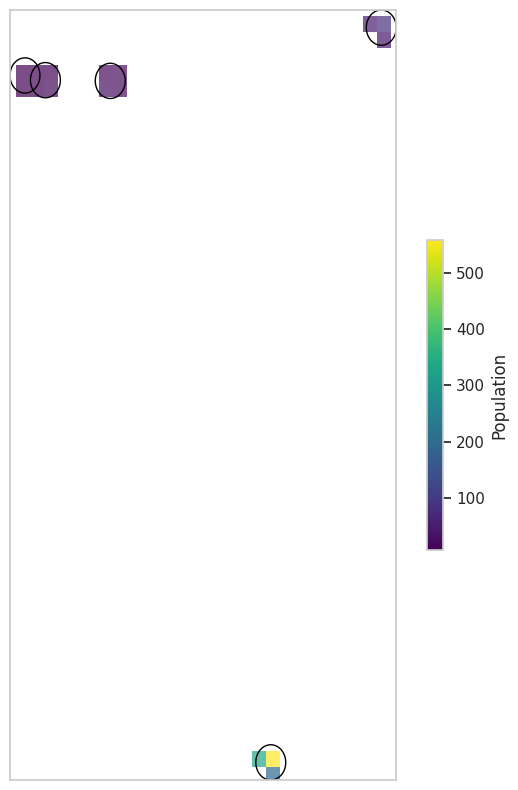

In [ ]:
plot_polygons_with_cropped_raster_and_legend(algeria_schools_buffers_gdf.iloc[0:5, :], pop_filepath)

Then, we can use the `rasterstats` library to sum the population inside each school's buffer area.

In [ ]:
# Restrict to first 100 schools for faster processing
algeria_schools_buffers_gdf = algeria_schools_buffers_gdf.iloc[:100,:]
algeria_schools_gdf = algeria_schools_gdf.iloc [:100,:]
# Get population counts
population_in_buffer = zonal_stats(algeria_schools_buffers_gdf, pop_filepath, stats='sum')
algeria_schools_gdf['population_in_buffer'] = list(pd.DataFrame(population_in_buffer).iloc[:, 0])

### Descriptive statistics

We can see that the average school has about 12,000 people living in a 1 kilometer area around it.

In [ ]:
dfSummary(algeria_schools_gdf[['population_in_buffer']])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,population_in_buffer[float64],Mean (sd) : 6665.3 (6285.5)min < med < max:26.8 < 4941.9 < 28172.2IQR (CV) : 6841.8 (1.1),88 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3cu47aQBSA4TPcZC9oRpYT6Gi238KlH2IfNq+AxBNQpElFh2QhIxwQyDhFdqUo0kI8wfJh/X8tGhuJHzy+DKaqKgG06LX9BoA/Da69aIwJRWTkue1TVVUHz7HoqA+DNMaEcRy/Wmsjnw3vdrutMeYbUaKOa7+QI2ttlKbpwTl3rLPRPM+D5XIZZVk2EhGCxD+7esgWEXHOHafT6U+PbYceY9BxnNRAFYKEKgQJVQgSqhAkVCFIqHLzso+vsiyHImKNMT7DucvTUY0EWRTF8Hw+v8zn836/3691UV2Euzxd1kiQp9NpEATBU5Ikx9lstq0zlrs83dbYIVtEZDwec5cHtXBSA1UIEqoQJFQhSKhCkFCFIKEKQUIVgoQqBAlVCBKqECRUIUioQpBQhSChCkFCFYKEKgQJVQgSqhAkVGl0TY0vltB2l7ogWULbbeqC/N8ltIvFYppl2RdjzM5n94TcLnVBvvNZQsuv6+NTG6QP/qDg8X2qIN/xBwWPi8s+UIUgoQpBQhWChCoECVUIEqoQJFQhSKhCkFCFIKEKQUIVgoQqn/LhCl88qd4+gnzDs5Q6EOQbnqXUgSD/wrOU7SLIO2lr/mmMCUVk5DNWfp/UXjzHNjJnJsg7aGv+aYwJ4zh+tdZGdfdZluWwKIrnyWTyo9frneuOb2rOTJB30OL8c2StjdI0PTjnan0R1ut1tFqtviZJ8l3T6k6CvKO25p/Oudr73W63oYi+1Z0EidqaPCIQJLw1cUS4GWSe50Hdve33+0BEpCiKYLPZPDH2Y3meB2VZDsTvDN1eLpfBI31Gt97rLzM9kIVetKLGAAAAAElFTkSuQmCC"">",0(0.0%)


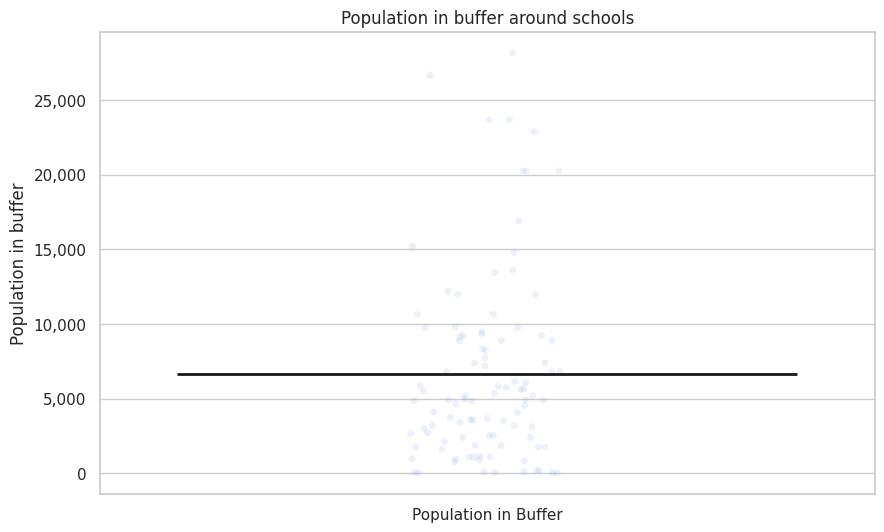

In [ ]:
# @title Figure
# Prepare the data for the box plot
data = algeria_schools_gdf[['population_in_buffer']].copy()
data['Distance Type'] = 'Population in Buffer'

# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create a box plot for the population in buffer
plt.figure(figsize=(10, 6))
sns.boxplot(x='Distance Type', y='population_in_buffer', data=data, palette='muted', hue='Distance Type',
            showfliers=False, showbox=False, showcaps=False, showmeans=True, meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10)

# Overlay jittered points using stripplot
sns.stripplot(x='Distance Type', y='population_in_buffer', data=data, palette='muted', alpha=0.1, jitter=True, hue='Distance Type')

# Set labels and title
plt.xlabel('')
plt.ylabel('Population in buffer')
plt.title('Population in buffer around schools')

# Format y-axis with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)